#### Env: Minh

In [8]:
import pandas as pd
from upgrade import *
from causallearn.utils.cit import CIT
import numpy as np
from pathlib import Path
import os
from tqdm import tqdm

dataname = "asia"
# dataname = "erdos_renyi/d40_p0.1"
mi = 3      # The number of values a variable can take is ranged in [2, mi-1]
di = 1      # The dirichlet alpha that controls the data distribution
n = 10      # The number of data silos

silos = []

folderpath = f"./data/distributed/{dataname}/m{mi}_d{di}_n{n}"
groundtruth = np.loadtxt(f"./data/distributed/{dataname}/adj.txt")

if not Path(folderpath).exists():
    print("Folder", folderpath, "not exist!")
else:
    for file in sorted(os.listdir(folderpath)):
        filename = os.path.join(folderpath, file)
        silo_data = pd.read_csv(filename)
        silos.append(silo_data)
        print("Loaded file:", filename, end="\t")
        print(len(silo_data), " Instances", len(silo_data.columns), "Variables")

merged_df = pd.concat(silos[:-1], axis=0)
merged_df = merged_df.reindex(sorted(merged_df.columns, key=lambda item: int(item[1:])), axis=1)
all_vars = list(merged_df.columns)

Loaded file: ./data/distributed/asia/m3_d1_n10/silo-0.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-1.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-2.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-3.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-4.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-5.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-6.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-7.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-8.csv	5000  Instances 8 Variables
Loaded file: ./data/distributed/asia/m3_d1_n10/silo-9.csv	5000  Instances 8 Variables


In [57]:
confidence = 0.01
connectivity = {var: [] for var in all_vars}
chisq_obj = CIT(merged_df, "chisq")

for X in connectivity.keys():
    other_vars = list(set(all_vars) - set(connectivity[X]) - set([X]))
    for Y in other_vars:
        pval = chisq_obj(all_vars.index(X), all_vars.index(Y), []) # type: ignore
        if pval <= confidence: # type: ignore
            connectivity[X] = list(set(connectivity[X]) | set([Y]))
            connectivity[Y] = list(set(connectivity[Y]) | set([X]))

In [125]:
connectivity

{'X1': ['X8', 'X3', 'X2', 'X5', 'X4', 'X7', 'X6'],
 'X2': ['X8', 'X3', 'X5', 'X7', 'X1', 'X6'],
 'X3': ['X8', 'X2', 'X5', 'X4', 'X1', 'X6'],
 'X4': ['X8', 'X3', 'X5', 'X7', 'X1', 'X6'],
 'X5': ['X8', 'X3', 'X2', 'X4', 'X1', 'X6'],
 'X6': ['X8', 'X3', 'X2', 'X5', 'X4', 'X1', 'X7'],
 'X7': ['X8', 'X2', 'X4', 'X1', 'X6'],
 'X8': ['X3', 'X2', 'X5', 'X4', 'X7', 'X1', 'X6']}

In [58]:
basis = []
ordering = sorted(all_vars, key=lambda item: len(connectivity[item]), reverse=False)
print(ordering)

while len(ordering):
    x = ordering.pop(0)
    discard_vars = connectivity[x]
    ordering = sorted(list(set(ordering) - set(discard_vars)), 
                    key=lambda item: len(list(set(connectivity[item]) - set(discard_vars))), reverse=False)
    basis.append(x)
    
basis

['X7', 'X2', 'X3', 'X4', 'X5', 'X1', 'X6', 'X8']


['X7', 'X3']

In [59]:
from copy import deepcopy

def GSMB(indexes, confidence=0.01):
    data = merged_df.iloc[indexes].reset_index().drop(columns=['index'])
    chisq_obj = CIT(data, "chisq") # construct a CIT instance with data and method name
    all_var_idx = [i for i in range(len(data.columns))]
    markov_blankets_idx = {i: [] for i in range(len(data.columns))}

    for X in all_var_idx:
        S = []
        prev_length = 0
        count = 0
        while True:
            count += 1
            # print("==============New cycle==================")
            for Y in list(set(all_var_idx) - set(S) - set([X])):
                if Y != X:
                    pval = chisq_obj(X, Y, S) # type:ignore
                    if pval <= confidence: # type:ignore
                        S.append(Y)
            
            for Y in deepcopy(S):
                pval = chisq_obj(X, Y, list(set(S) - set([Y]))) # type:ignore
                if pval > confidence: # type:ignore
                    S.remove(Y)
            
            if (len(S) - prev_length == 0) or (count > 2):
                break
            else:
                prev_length = len(S)
        markov_blankets_idx[X] = list(set(markov_blankets_idx[X])|set(S))
    
    markov_blankets = {var: [] for var in all_vars}
    for idx, mb_idxes in markov_blankets_idx.items():
        var = all_vars[idx]
        markov_blankets[var] = [all_vars[i] for i in mb_idxes]
    
    return markov_blankets

In [60]:
def true_markov_blanket(adj_matrix, var_idx):
    parents = np.where(adj_matrix[:, var_idx])[0].tolist()
    children = np.where(adj_matrix[var_idx])[0].tolist()
    
    spouses = set()
    for c in children:
        for sp in np.where(adj_matrix[:, c])[0]:
            spouses.add(sp)
    
    pa_sp = list(set(parents)&spouses)
    ch_sp = list(set(children)&spouses)
    spouses = list(spouses - set(pa_sp) - set(ch_sp))
    
    return parents, pa_sp, spouses, ch_sp, children


def to_list(all_vars, mb_idx_list):
    return [all_vars[i] for i in mb_idx_list]

In [61]:
TMB_activated = 1
markov_blankets = {var: [] for var in all_vars}

if TMB_activated:
    for var in markov_blankets.keys():
        pa, pa_sp, sp, ch_sp, ch = true_markov_blanket(groundtruth, int(var[1:]) - 1)
        markov_blankets[var] = list(set(to_list(all_vars, pa + pa_sp + sp + ch_sp + ch)) - set([var]))
else:
    markov_blankets = GSMB([i for i in range(len(merged_df))])

In [62]:
def generate_uniform_distributions(P0: np.ndarray, num_gen=100, gamma2=0.8):
    Ulist = list(np.eye(P0.shape[0]))
    # Compute the boundary points
    boundaries = []
    for i in range(len(Ulist)):
        if P0[i]/gamma2 < 1:
            alpha_i = 1/(1 - P0[i]) * (1 - P0[i]/(gamma2 + 0.001))
            boundary_i = alpha_i * P0 + (1 - alpha_i) * Ulist[i]
        else:
            boundary_i = Ulist[i]
        boundaries.append(boundary_i)
    
    boundaries = np.stack(boundaries)
    w = np.concatenate([np.random.dirichlet([alpha/2] * len(Ulist), size=num_gen) for alpha in range(1, 10)])
    
    kmeans = KMeans(n_clusters=num_gen, n_init="auto")
    kmeans.fit(w @ boundaries)
    res = kmeans.cluster_centers_
    
    return res

def multivariate_sampling(data: pd.DataFrame, variables: list, sample_dis: dict, instance_index):
    remains = deepcopy(variables)
    while len(remains):
        sampling_var = remains.pop(0)
        distribution = sample_dis[sampling_var][instance_index]
        _, all_index = univariate_sampling(data, sampling_var, {i: distribution[i] for i in range(distribution.shape[0])})
    return all_index

In [63]:
def recursive_conn(neighbors):
    output = []
    if len(neighbors) <= 1:
      output = [neighbors]
    else:
      for i in neighbors:
        res_i = [i] + recursive_conn(list(set(neighbors)&set(markov_blankets[i])))
        output.append(res_i)
    return output

def unfold(input):
    """
    Arguments:
      input: [var, var, ..., [var, ...], [var, ...]]

    that has a number of non-list element and a number of list element
    """
    cut_index = 0
    while cut_index < len(input):
      cut_index += 1
      if isinstance(input[cut_index], list):
        break

    out = []
    for i in range(cut_index, len(input)):
      out.append([*input[:cut_index], *input[i]])
    return out

In [64]:
recursive_outputs = {}

for anchor_var in tqdm(markov_blankets.keys()):
    recursive_outputs[anchor_var] = recursive_conn(deepcopy(markov_blankets[anchor_var]))

100%|██████████| 8/8 [00:00<00:00, 26379.27it/s]


In [65]:
potential_parents = {}

for anchor_var in tqdm(markov_blankets.keys(), leave=False):
    # anchor_var = 'X1'
    recursive_output = recursive_outputs[anchor_var]

    final_output = set()
    for i in range(len(recursive_output)):
        test_case = deepcopy(recursive_output[i])
        unique_elements = set()
        if len(test_case) == 1:
            unique_elements.add(tuple(test_case))
        else:
            first_element = test_case.pop(0)
            while len(test_case):
                examine_group = test_case.pop(0)
                if len(examine_group) and not isinstance(examine_group[0], list) and isinstance(examine_group[-1], list):
                    test_case += [*unfold(examine_group)]
                else:
                    unique_elements.add(tuple(sorted(examine_group + [first_element])))
        
        final_output = final_output|unique_elements
    potential_parents[anchor_var] = [j for j in final_output]

In [66]:
def compute_variance_viaindexesv2(indexes: list, variable: str, parents: list):
    conditional_probs_record = merged_df[parents + [variable]].groupby(parents + [variable]).count().reset_index()
    mll_list = []
    env = 0
    for index in indexes:
        vertical_sampled_data = merged_df.iloc[index].reset_index()
        vertical_sampled_data = vertical_sampled_data.drop(columns=['index'])
        vertical_sampled_data.insert(0, 'count', [1] * len(vertical_sampled_data))
        
        summary_with_ch = vertical_sampled_data.groupby(parents + [variable])['count'].sum().reset_index()
        mll, output = compute_mll(summary_with_ch, parents, env)
        conditional_probs_record = conditional_probs_record.merge(output, on=parents + [variable], how='left')
        mll_list.append(mll)
        env += 1
    
    mean_mll = np.mean(mll_list)
    var_avg = conditional_probs_record.iloc[:, len(parents) + 1:].var(axis=1, skipna=True).mean()
    return var_avg, mean_mll, conditional_probs_record


def compute_weighted_variance_viaindexesv2(indexes: list, variable: str, parents: list):
    variance, _, df = compute_variance_viaindexesv2(indexes, variable, parents)
    if len(parents):
        joint_mat = np.array([df[f'joint_{i}'] for i in range(len(indexes))]).T
        probs_mat = np.array([df[f'probs_{i}'] for i in range(len(indexes))]).T
        probs_mean = []
        for i in range(probs_mat.shape[0]):
            if len(probs_mat[i][~np.isnan(probs_mat[i])]):
                probs_mean.append(np.mean(probs_mat[i][~np.isnan(probs_mat[i])]).item())
            else:
                probs_mean.append(0)
                
        probs_mean = np.expand_dims(np.array(probs_mean), 1)
        # joint_mat = joint_mat.shape[1] * joint_mat/joint_mat.sum(axis=1, keepdims=True)
        prod = joint_mat * (probs_mat - probs_mean)**2
        return np.power(np.mean(prod[~np.isnan(prod)]), 0.5), parents
    else:
        return variance, parents

#### Version 2 -- Given the leaves

In [67]:
from multiprocessing import Pool
from typing import List, Tuple


def individual_causal_search(var, silos_index):
    record = {}
    for mb_var in markov_blankets[var]:
        variance, _ = compute_weighted_variance_viaindexesv2(silos_index, var, [mb_var])
        record[tuple([mb_var])] = variance
    return {var: record}


# Function to execute F in parallel
def execute_in_parallel(args_list: List[Tuple]):
    with Pool() as pool:
        # Map the function F to the arguments in parallel
        results = pool.starmap(individual_causal_search, args_list)
    return results

In [112]:
leaves = ['X8']

In [113]:
num_env = 10
gamma2 = 0.5

sample_dis = {x: generate_uniform_distributions(P0=marginal_prob(merged_df, [x]),
                                                num_gen=num_env, 
                                                gamma2=np.power(gamma2, 1./len(leaves))) for x in leaves}
silos_index = [multivariate_sampling(merged_df, leaves, sample_dis, i) for i in range(num_env)]

inputs = [(var, silos_index) for var in markov_blankets.keys()]
outputs = execute_in_parallel(inputs)

results = tuple()
for out_dict in outputs:
    results += tuple(out_dict.items())

results = dict(results)

In [114]:
weighted_mtx = np.ones([len(all_vars), len(all_vars)])

for var in results.keys(): #type:ignore
    var_id = all_vars.index(var)
    best_comb, best_variance = min(results[var].items(), key=lambda item: item[1])
    # print(var, best_comb, best_variance)
    
    for parent in best_comb:
        pa_id = all_vars.index(parent)
        if best_variance < weighted_mtx[var_id][pa_id]:
            weighted_mtx[pa_id][var_id] = best_variance
            weighted_mtx[var_id][pa_id] = 1

In [115]:
weighted_mtx[weighted_mtx == 1] = 0
adj_mtx = (weighted_mtx > 0) * 1
adj_mtx = adj_mtx.T
# adj_mtx

In [116]:
from plot_utils import true_edge, spur_edge, fals_edge, miss_edge, swap_pos

etrue = true_edge(groundtruth, adj_mtx)
espur = spur_edge(groundtruth, adj_mtx)
efals = fals_edge(groundtruth, adj_mtx)
emiss = miss_edge(groundtruth, adj_mtx)

print(len(etrue), len(espur), len(emiss), len(efals))

6 2 1 1


In [117]:
sources_idx = np.array([i for i in range(len(all_vars)) if np.sum(adj_mtx[:, i]) == 0])
sources = np.array(all_vars)[sources_idx].tolist()
sources = list(set(sources) - set(basis))
sources

['X1', 'X3', 'X5']

#### Version 1 -- Given the sources

In [118]:
# sources = ['X2', 'X5']

In [119]:
from multiprocessing import Pool
from typing import List, Tuple
from itertools import combinations

capsize = 8

def individual_causal_search(var, silos_index):
    buffers = {}
    for group in sorted(potential_parents[var], key=lambda item: len(item)):
        for l in range(1, min(len(group)+1,capsize)).__reversed__():
            for comb in combinations(group, l):
                comb = tuple(sorted(comb))
                if comb not in buffers.keys():
                    variance, _ = compute_weighted_variance_viaindexesv2(silos_index, var, list(comb))
                    buffers[comb] = variance
    return {var: buffers}


# Function to execute F in parallel
def execute_in_parallel(args_list: List[Tuple]):
    with Pool() as pool:
        # Map the function F to the arguments in parallel
        results = pool.starmap(individual_causal_search, args_list)
    return results

In [120]:
num_env = 10
gamma2 = 0.5

sample_dis = {x: generate_uniform_distributions(P0=marginal_prob(merged_df, [x]),
                                                num_gen=num_env, 
                                                gamma2=np.power(gamma2, 1./len(sources))) for x in sources}
silos_index = [multivariate_sampling(merged_df, sources, sample_dis, i) for i in range(num_env)]

inputs = [(var, silos_index) for var in markov_blankets.keys()]
outputs = execute_in_parallel(inputs)

results = tuple()
for out_dict in outputs:
    results += tuple(out_dict.items())

results = dict(results)

In [121]:
weighted_mtx = np.ones([len(all_vars), len(all_vars)])

for var in results.keys(): #type:ignore
    var_id = all_vars.index(var)
    best_comb, best_variance = min(results[var].items(), key=lambda item: item[1])
    # print(var, best_comb, best_variance)
    
    for parent in best_comb:
        pa_id = all_vars.index(parent)
        if best_variance < weighted_mtx[var_id][pa_id]:
            weighted_mtx[pa_id][var_id] = best_variance
            weighted_mtx[var_id][pa_id] = 1

In [122]:
hardcap_invariance = 1e-3
weighted_mtx[weighted_mtx > hardcap_invariance] = 0
adj_mtx = (weighted_mtx > 0) * 1
# adj_mtx

In [123]:
from plot_utils import true_edge, spur_edge, fals_edge, miss_edge, swap_pos

etrue = true_edge(groundtruth, adj_mtx)
espur = spur_edge(groundtruth, adj_mtx)
efals = fals_edge(groundtruth, adj_mtx)
emiss = miss_edge(groundtruth, adj_mtx)

print(len(etrue), len(espur), len(emiss), len(efals))

6 0 1 1


#### Plot -- Graphs

6 0 1 1


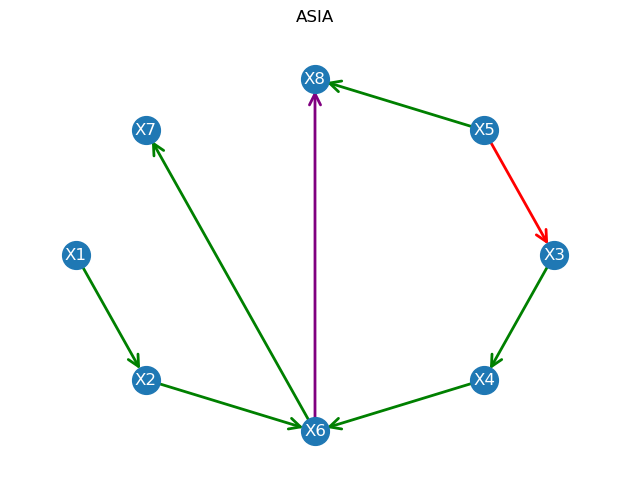

In [124]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()

fin_adjmtx = adj_mtx

for i in range(fin_adjmtx.shape[0]):
    for j in range(fin_adjmtx.shape[1]):
        if fin_adjmtx[i][j] > 0:
            G.add_edge(f"X{i+1}", f"X{j+1}", weight=np.round(1/fin_adjmtx[i][j],2))
            # print("Here add edge", f"X{i+1}", f"X{j+1}")
    G.add_node(f"X{i+1}")
    

etrue = true_edge(groundtruth, fin_adjmtx)
espur = spur_edge(groundtruth, fin_adjmtx)
efals = fals_edge(groundtruth, fin_adjmtx)
emiss = miss_edge(groundtruth, fin_adjmtx)

# print(etrue)
print(len(etrue), len(espur), len(emiss), len(efals))

pos = nx.shell_layout(G)
pos = swap_pos(pos, 'X4', 'X3')
# pos = swap_pos(pos, 'X3', 'X5')

# nodes
nx.draw_networkx_nodes(G, pos, node_size=400, node_color="#1f78b4")

# edges
nx.draw_networkx_edges(G, pos, edgelist=espur, width=2, arrowstyle='->', arrowsize=20, edge_color="orange", label="Spurious Edges")
nx.draw_networkx_edges(G, pos, edgelist=emiss, width=2, arrowstyle='->', arrowsize=20, edge_color="purple", label="Missing Edges")
nx.draw_networkx_edges(G, pos, edgelist=efals, width=2, arrowstyle='->', arrowsize=20, edge_color="red", label="Anti-Causal Edges")
nx.draw_networkx_edges(G, pos, edgelist=etrue, width=2, arrowstyle='->', arrowsize=20, edge_color="green", label="Causal Edges")

# node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif", font_color='white')

# edge weight labels
# edge_labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
# plt.box()
plt.title(dataname.upper())
# plt.legend()
plt.show()

# plt.savefig("res/asia.plot.svg", format="svg")